# Figure show label distributions

Figure to generate the figure showing labels and their distributions

In [1]:
%matplotlib inline

import numpy as np
from catalog import Pink
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

/Users/gal16b/Documents/Postdoc_Work/PINK/Notebook/catalog.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/gal16b/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/gal16b/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/gal16b/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/gal16b/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/gal16b/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
  

In [2]:
pink = Pink.loader('Script_Experiments_Fractions_Trials/FIRST_Norm_NoLog_3_12x12_Trial0/trained.pink')

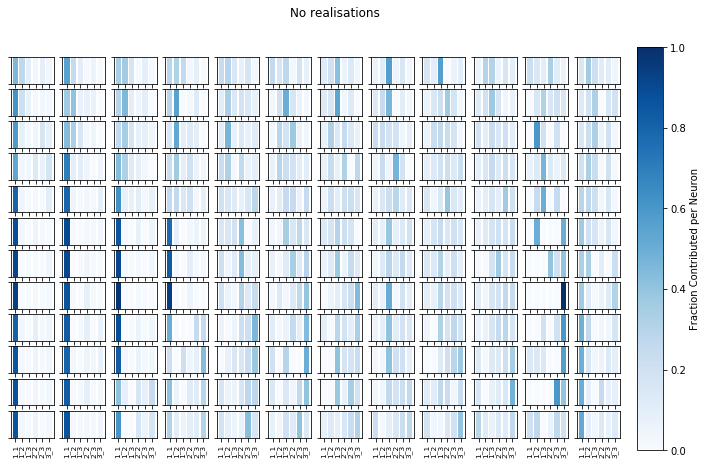

In [3]:
book, counts = pink.attribute_heatmap(mode='train', plot=True, xtick_rotation=90, color_map='Blues', figsize=(12,7), literal_path=True , save='Images/Label_Distribution_Map.pdf')

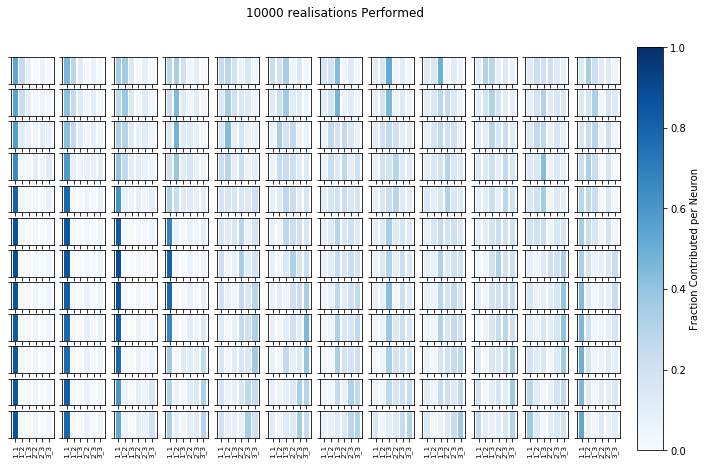

In [4]:
book, counts = pink.attribute_heatmap(mode='train', plot=True, xtick_rotation=90, color_map='Blues', figsize=(12,7),
                                     realisations=10000, literal_path=True , save='Images/Label_Distribution_Map_10000.pdf')

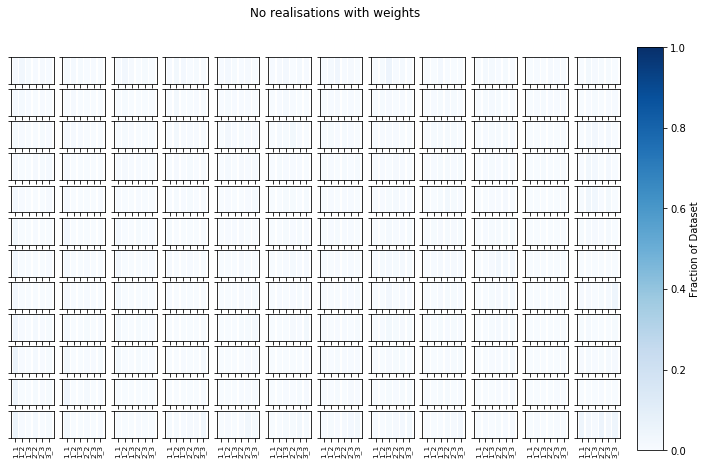

In [5]:
book, counts = pink.attribute_heatmap(mode='train', plot=True, xtick_rotation=90, color_map='Blues', figsize=(12,7), weights=True)

# Function specific plotting routines

I am going to attempt to make slightly better plots in this notebook. Functions will be written and executed here. 


In [6]:
def get_shape(book):
    max_shape = 0

    for i in book.keys():
        curr_shape = i[0]*i[1]
        if curr_shape > max_shape:
            max_shape = curr_shape
            shape = i

    return shape

def label_plot(book, shape, save=None, xtick_rotation=None, 
                color_map='gnuplot2', title=None, weights=None, figsize=(6,6),
                literal_path=False, count_text=False):
    '''Isolated function to plot the attribute histogram if the data is labelled in 
    nature

    book - dict
        A dictionary whose keys are the location on the heatmap, and values
        are the list of values of sources who most belonged to that grid
    shape - tuple
        The shape of the grid. Should attempt to get this from the keys or
        possible recreate it like in self.attribute_heatmap() 
    save - None or Str
        If None, show the figure on screen. Otherwise save to the path in save
    xtick_rotation - None or float
        Will rotate the xlabel by rotation
    color_map - str
        The name of the matplotlib.colormap that will be passed directly to matplotlib.pyplot.get_map()
    title - None of str
        A simple title strng passed to fig.suptitle()
    weights - None or dict
        If not None, the dict will have keys corresponding to the labels, and contain the total
        set of counts from the Binary file/book object. This will be used to `weigh` the contribution
        per neuron, to instead be a fraction of dataset type of statistic. 
    figsize - tuple of int
        Size of the figure to produce. Passed directly to plt.subplots
    literal_path - bool
        If true, take the path and do not modify it. If False, prepend the project_dir path
    count_label - bool
        If true, put as an anotation the counts of items in that neuron plot
    '''
    # Need access to the Normalise and ColorbarBase objects
    import matplotlib as mpl
    # Step one, get unique items and their counts
    from collections import Counter
    unique_labels = []
    max_val = 0
    for k, v in book.items():
        v = [i for items in v for i in items]
        c = Counter(v)
        unique_labels.append(c.keys())

        # Guard agaisnt empty most similar neuron
        if len(v) > 0:
            mv = max(c.values())
            max_val = mv if mv > max_val else max_val

    # Work out the unique labels and sort them so that each 
    # sub pplot may be consistent. Calling Counter object 
    # with a key that doesnt exits returns 0. Exploit this 
    # when plotting the bars
    unique_labels = list(set([u for labels in unique_labels for u in labels]))
    unique_labels.sort()

    cmap = plt.get_cmap(color_map)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    fig, ax = plt.subplots(nrows=shape[0]+1, ncols=shape[1]+1, figsize=figsize)

    # Set empty axis labels for everything
    for a in ax.flatten():
        a.set(xticklabels=[], yticklabels=[])

    # Keep track of range for the color bar normalisation
    norm_max = 0  
    for k, v in book.items():
        v = [i for items in v for i in items]
        c = Counter(v)
        s = sum(c.values())

        # Guard agaisnt most similar empty neuron
        if s > 0:
            # If we have weights, use them to weight the value of the labels
            # otherwise just weight by the sum of items in the neuron
            if weights is not None:
                values = [c[l]/weights[l] for l in unique_labels]
                norm_max = max(values) if max(values) > norm_max else norm_max

                color = cmap(values)
            else:
                norm_max = 1
                color = cmap([c[l]/s for l in unique_labels])

            ax[k].bar(np.arange(len(unique_labels)),
                     [1]*len(unique_labels),
                     color=color,
                     align='center',
                     tick_label=unique_labels)

        ax[k].set(ylim=[0,1])
        if k[1] != -1: # disable this for now.
            ax[k].set(yticklabels=[])
        if k[0] != shape[1]:
            ax[k].set(xticklabels=[])
        else:
            if xtick_rotation is not None:
                ax[k].tick_params(axis='x', rotation=xtick_rotation)
                for item in ax[k].get_xticklabels():
                    item.set_fontsize(7.5)

        if count_text:
            bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
            if isinstance(count_text, tuple):
                ax[k].annotate(f'{len(v)}', xy=count_text, xycoords='axes fraction', bbox=bbox_props)
            else:
                ax[k].annotate(f'{len(v)}', xy=(0.1,0.65), xycoords='axes fraction', bbox=bbox_props)
                
                    
    fig.subplots_adjust(right=0.83)
    cax = fig.add_axes([0.85, 0.10, 0.03, 0.8])

    # Need to calculate the values, then create the color map with the
    # attached norm object, then plot, then this will work correctly. 

    # norm = mpl.colors.Normalize(vmin=0, vmax=norm_max)        
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

    if weights is None:
        cb1.set_label('Fraction Contributed per Neuron')
    else:
        cb1.set_label('Fraction of Dataset')

    if title is not None:
        fig.suptitle(title, y=0.9)

    # fig.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save)



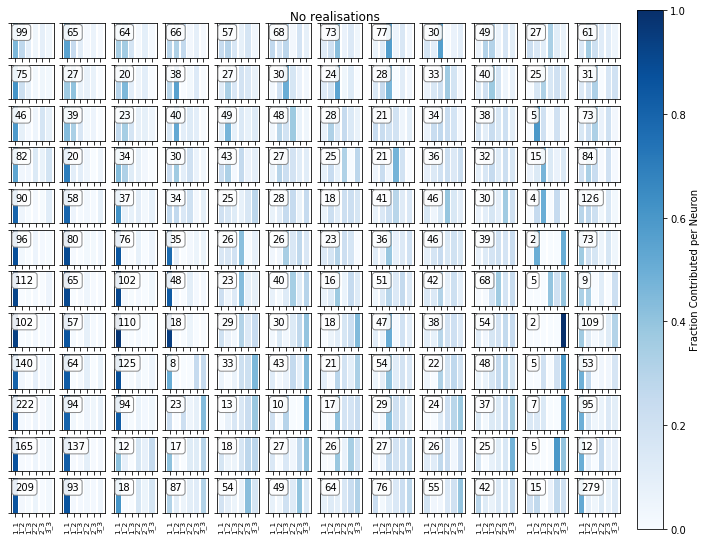

In [7]:
book, counts = pink.attribute_heatmap(mode='train', plot=False)
label_plot(book, get_shape(book), color_map='Blues', figsize=(12,9), xtick_rotation=90, count_text=True,
           title='No realisations', save='Images/Label_Distribution_Map_Counts.pdf')

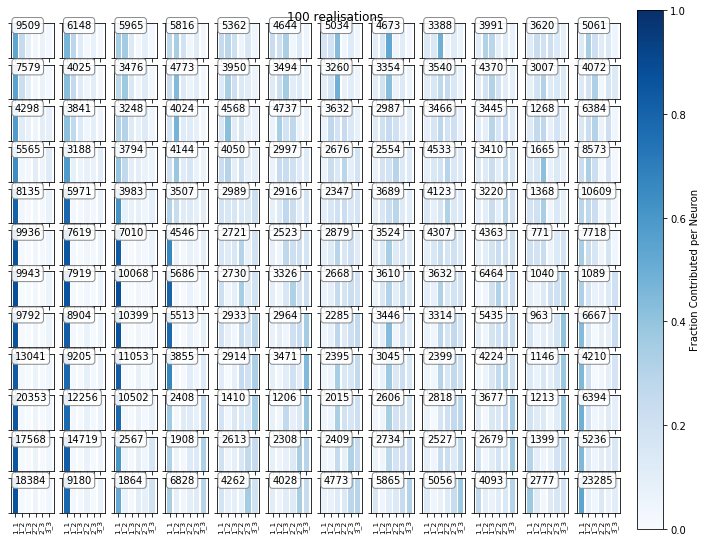

In [8]:
book, counts = pink.attribute_heatmap(mode='train', plot=False, realisations=100)
label_plot(book, get_shape(book), color_map='Blues', figsize=(12,9), xtick_rotation=90, count_text=(0.1, 0.85),
           title='100 realisations', save='Images/Label_Distribution_Map_Counts_100.pdf')